In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import string

In [3]:
df = pd.read_csv(
    "WELFake_Dataset.csv",
    quotechar='"',        
    escapechar='\\',      
    on_bad_lines='warn',  
    engine='python'       
)

Skipping line 329: field larger than field limit (131072)
Skipping line 6464: field larger than field limit (131072)
Skipping line 8627: ',' expected after '"'
Skipping line 335: Expected 4 fields in line 335, saw 6
Skipping line 6463: Expected 4 fields in line 6463, saw 7
Skipping line 6464: Expected 4 fields in line 6464, saw 10
Skipping line 6466: Expected 4 fields in line 6466, saw 14
Skipping line 6468: Expected 4 fields in line 6468, saw 8
Skipping line 6469: Expected 4 fields in line 6469, saw 5
Skipping line 6470: Expected 4 fields in line 6470, saw 7
Skipping line 6471: Expected 4 fields in line 6471, saw 15
Skipping line 6472: Expected 4 fields in line 6472, saw 9
Skipping line 6473: Expected 4 fields in line 6473, saw 9
Skipping line 6474: Expected 4 fields in line 6474, saw 12
Skipping line 6475: Expected 4 fields in line 6475, saw 15
Skipping line 6476: Expected 4 fields in line 6476, saw 8
Skipping line 6477: Expected 4 fields in line 6477, saw 20
Skipping line 6478: Expe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72153 entries, 0 to 72152
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72153 non-null  object
 1   title       71588 non-null  object
 2   text        72096 non-null  object
 3   label       72133 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB


#Pre-Processing

In [7]:
df['label'].value_counts()
# 0 = Fake
# 1 = Not Fake (Real)

1                                                  37103
0                                                  35028
 is just unbelievably rich from North Sea oil.         1
 за участие. Благодарю вас.                            1
Name: label, dtype: int64

In [8]:
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)


In [9]:
print(df['label'].value_counts())
print(df['label'].dtype)


1    37103
0    35028
Name: label, dtype: int64
int64


In [10]:
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [11]:

# Dropping unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop rows with missing title or text
df.dropna(subset=['title', 'text'], inplace=True)

print("After cleaning:")
print(df.isna().sum())
print(df.shape)


After cleaning:
title    0
text     0
label    0
dtype: int64
(71534, 3)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71534 entries, 0 to 72152
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71534 non-null  object
 1   text    71534 non-null  object
 2   label   71534 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [13]:
df['title'].duplicated().sum()

9229

In [14]:
df['combined'] = df['title'].str.strip() + " " + df['text'].str.strip()
df.duplicated(subset='combined').sum()


8418

In [15]:
dup_check = df[df.duplicated(subset='combined', keep=False)]
conflict = dup_check.groupby('combined')['label'].nunique()
print(conflict[conflict > 1])


Series([], Name: label, dtype: int64)


In [16]:
df.drop_duplicates(subset='combined', inplace=True)
df.drop(columns=['combined'], inplace=True)  # optional cleanup

In [17]:
print("Cleaned dataset shape:", df.shape)
print("Remaining missing values:\n", df.isna().sum())
print("Label distribution:\n", df['label'].value_counts())

Cleaned dataset shape: (63116, 3)
Remaining missing values:
 title    0
text     0
label    0
dtype: int64
Label distribution:
 0    34790
1    28326
Name: label, dtype: int64


In [18]:
df.duplicated().sum()

0

#Exploratory Analysis

In [19]:
# Calculating average word count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))


average_words = df['word_count'].mean()
print(f"Average article length (in words): {average_words:.2f}")


Average article length (in words): 545.95


In [20]:
# Calculating average word count
df['char_count'] = df['text'].apply(len)
average_chars = df['char_count'].mean()
print(f"Average article length (in characters): {average_chars:.2f}")


Average article length (in characters): 3298.73


/var/tmp/ipykernel_4294/1530297666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='word_count_bucket', order=labels, palette='viridis')


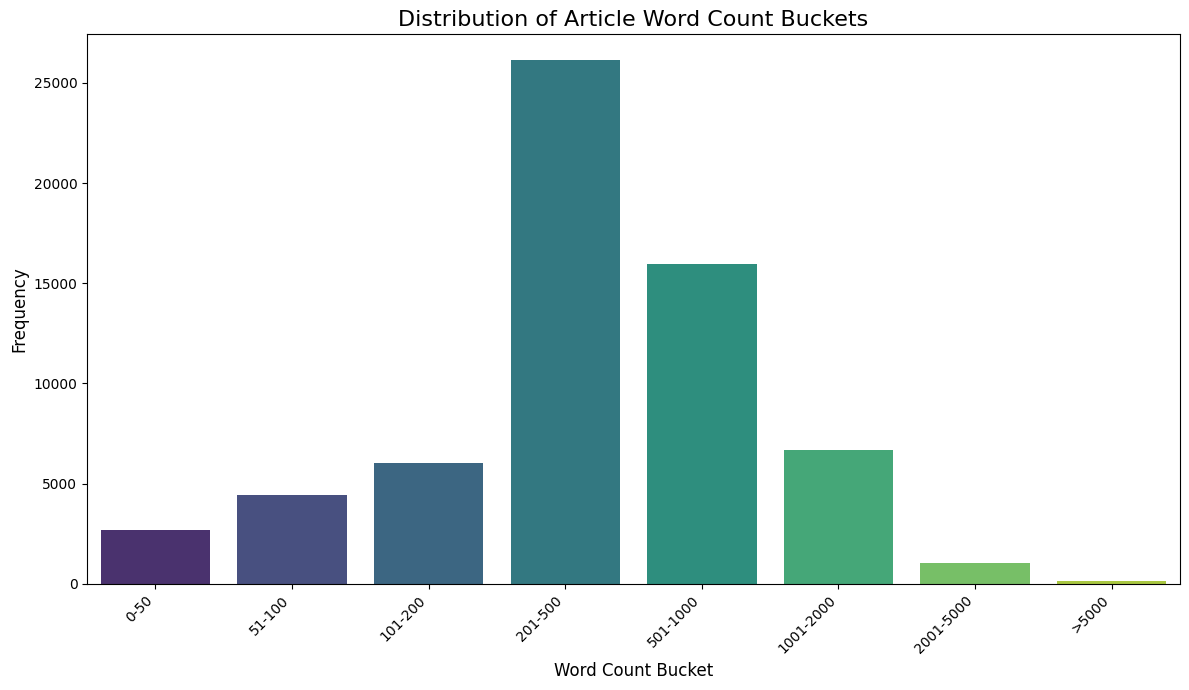

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0, 50, 100, 200, 500, 1000, 2000, 5000, np.inf]
labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-5000', '>5000']
df['word_count_bucket'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True, include_lowest=True)

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='word_count_bucket', order=labels, palette='viridis')
plt.title("Distribution of Article Word Count Buckets", fontsize=16)
plt.xlabel("Word Count Bucket", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
df.groupby('label')['word_count'].mean()

label
0    578.266600
1    506.257149
Name: word_count, dtype: float64

In [23]:
# Calculate average word count in the title
df['word_count_title'] = df['title'].apply(lambda x: len(x.split()))
average_words_title = df['word_count_title'].mean()
print(f"Average title length (in words): {average_words_title:.2f}")

Average title length (in words): 11.99


In [24]:
df.groupby('label')['word_count_title'].mean()

label
0    11.052314
1    13.135106
Name: word_count_title, dtype: float64

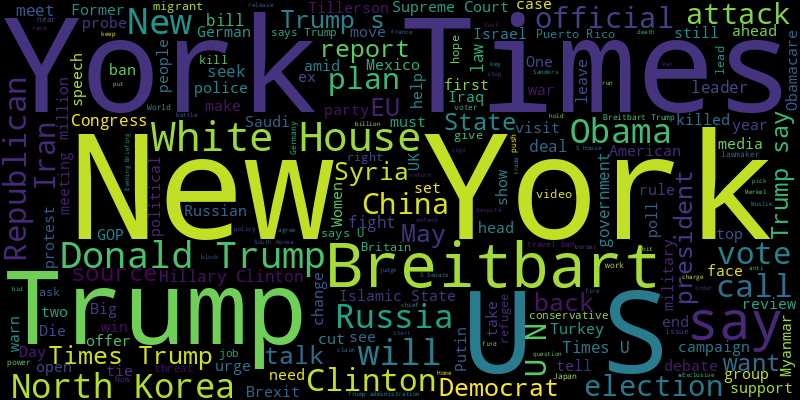

In [25]:
#Fake Title WordCloud
from wordcloud import WordCloud

fake_text = ' '.join(df[df['label'] == 0]['title'])
real_text = ' '.join(df[df['label'] == 1]['title'])

WordCloud(width=800, height=400).generate(fake_text).to_image()


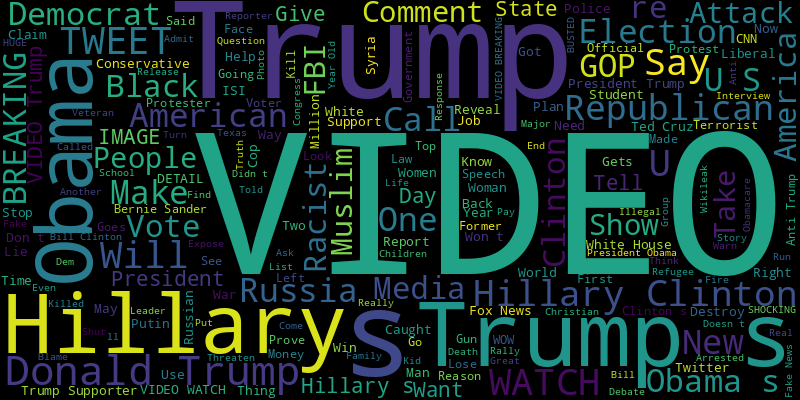

In [26]:
#Not Fake titles
from wordcloud import WordCloud

WordCloud(width=800, height=400).generate(real_text).to_image()


In [27]:
df.columns

Index(['title', 'text', 'label', 'word_count', 'char_count',
       'word_count_bucket', 'word_count_title'],
      dtype='object')

In [28]:
df.drop(columns=['word_count', 'char_count', 'word_count_bucket', 'word_count_title'], inplace=True)

In [29]:
df.isna().sum()
df.dropna(inplace=True)

#Natural Language Processing Data Cleaning

In [30]:
!pip install nltk

In [31]:
import html
import re
import string
from bs4 import BeautifulSoup\

df['title'] = df['title'].astype(str).str.lower()
df['text'] = df['text'].astype(str).str.lower()
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', str(x)))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
df['title'] = df['title'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
df['title'] = df['title'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', str(x)))
df['title'] = df['title'].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text())
df['text'] = df['text'].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text())
df['title'] = df['title'].apply(lambda x: html.unescape(str(x)))
df['text'] = df['text'].apply(lambda x: html.unescape(str(x)))


from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


df['title'] = df['title'].apply(
    lambda x: ' '.join([
        word.lower() for word in str(x).split()
        if word.lower() not in stop_words and 2 <= len(word) <= 20
    ])
)


df['text'] = df['text'].apply(
    lambda x: ' '.join([
        word.lower() for word in str(x).split()
        if word.lower() not in stop_words and 2 <= len(word) <= 20
    ])
)

df['title'] = df['title'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#Creating subset to reduce the size for faster run
df_subset = df.groupby('label').apply(lambda x: x.sample(n=22000, random_state=42)).reset_index(drop=True)


In [33]:
df_subset['label'].value_counts()

0    22000
1    22000
Name: label, dtype: int64

In [34]:
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 108.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [35]:
def batch_lemmatize(texts, batch_size=100, n_process=2):
    """
    Lemmatize a list of texts using spaCy's nlp.pipe for faster batch processing.

    Args:
        texts (List[str]): List of strings to lemmatize.
        batch_size (int): Number of documents to process in a batch.
        n_process (int): Number of parallel processes to use.

    Returns:
        List[str]: Lemmatized strings.
    """
    return [
        " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
        for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process)
    ]


In [36]:
#Lemmatization
titles = df_subset['title'].astype(str).tolist()
texts = df_subset['text'].astype(str).tolist()

df_subset['title'] = batch_lemmatize(titles, batch_size=100, n_process=2)
df_subset['text'] = batch_lemmatize(texts, batch_size=100, n_process=2)

In [37]:
# Final cleanup
df_subset['title'] = df_subset['title'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_subset['text'] = df_subset['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_subset['title'] = df_subset['title'].apply(lambda x: ' '.join(word for word in x.split() if word.isalpha()))
df_subset['text'] = df_subset['text'].apply(lambda x: ' '.join(word for word in x.split() if word.isalpha()))
df_subset = df_subset[df_subset['text'].str.split().str.len() > 5]

#Vectorization

#Bag of Words
Code block for Bag of Words Vectorizer, to be run while testing

In [38]:
df_master = df_subset.copy()
df_master['full_text'] = df_master['title'] + " " + df_master['text']

X_text = df_master['full_text']
y = df_master['label']

#Train Test Split
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.9
)

X1_train = bow_vectorizer.fit_transform(X_train_text)
X1_test = bow_vectorizer.transform(X_test_text)

print("Train shape:", X1_train.shape)
print("Test shape:", X1_test.shape)
print("Sample features:", bow_vectorizer.get_feature_names_out()[:20])


Train shape: (34673, 10000)
Test shape: (8669, 10000)
Sample features: ['aaron' 'abadi' 'abandon' 'abbas' 'abbott' 'abc' 'abc news' 'abdel'
 'abdullah' 'abe' 'abedin' 'abide' 'ability' 'able' 'aboard' 'abolish'
 'abortion' 'abortion right' 'abraham' 'abrams']


 Optimal number of components to retain ≥80% variance: 960
 Actual cumulative variance at 960 components: 0.80


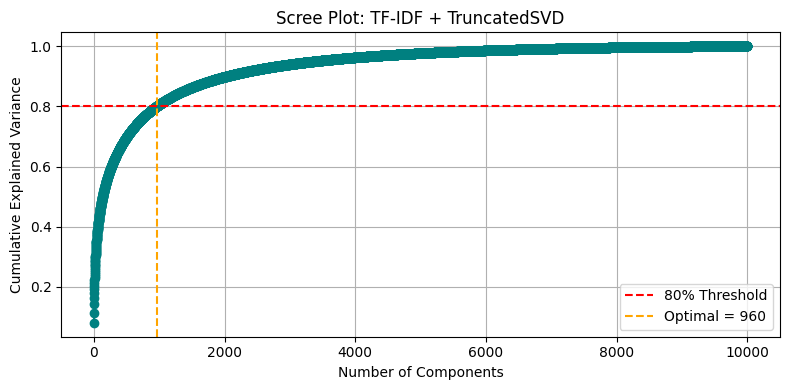

In [39]:
#Dimensionality reduction to capture 80% variance
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

max_components = X1_train.shape[1]
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X1_train)

cum_var = np.cumsum(svd_full.explained_variance_ratio_)

optimal_components = np.argmax(cum_var >= 0.80) + 1
print(f" Optimal number of components to retain ≥80% variance: {optimal_components}")
print(f" Actual cumulative variance at {optimal_components} components: {cum_var[optimal_components-1]:.2f}")

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='teal')
plt.axhline(y=0.80, color='red', linestyle='--', label='80% Threshold')
plt.axvline(x=optimal_components, color='orange', linestyle='--', label=f'Optimal = {optimal_components}')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: TF-IDF + TruncatedSVD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
svd = TruncatedSVD(n_components=optimal_components, random_state=42)
X1_train = svd.fit_transform(X1_train)
X1_test = svd.transform(X1_test)


Total Explained Variance by 300 components: 0.80


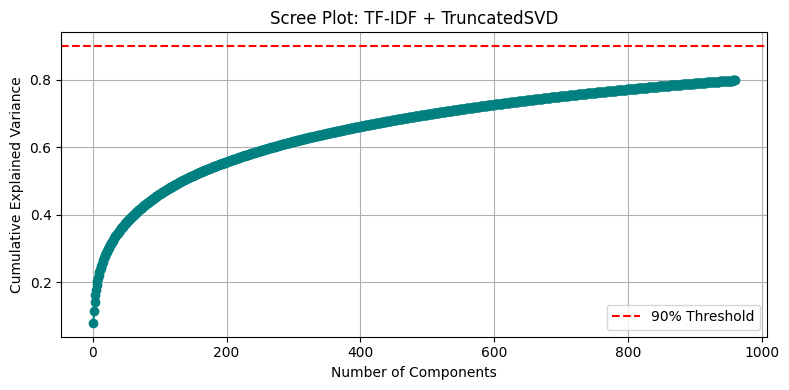

In [41]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Total Explained Variance by 300 components: {svd.explained_variance_ratio_.sum():.2f}")
cum_var = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='teal')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: TF-IDF + TruncatedSVD")
plt.grid(True)
plt.axhline(y=0.90, color='red', linestyle='--', label='90% Threshold')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
print(y.unique())
print(y.dtype)

[0 1]
int64


#TF-IDF
Code block for TF-IDF Vectorizer, to be run while testing

In [ ]:
df_master = df_subset.copy()
df_master['full_text'] = df_master['title'] + " " + df_master['text']

X_text = df_master['full_text']
y = df_master['label']
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.9
)

X1_train = tfidf_vectorizer.fit_transform(X_train_text)
X1_test = tfidf_vectorizer.transform(X_test_text)

print("Train shape:", X1_train.shape)
print("Test shape:", X1_test.shape)
print("Sample features:", tfidf_vectorizer.get_feature_names_out()[:20])

In [ ]:
from sklearn.decomposition import TruncatedSVD

max_components = X1_train.shape[1]
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X1_train)

cum_var = np.cumsum(svd_full.explained_variance_ratio_)

optimal_components = np.argmax(cum_var >= 0.80) + 1
print(f" Optimal number of components to retain ≥80% variance: {optimal_components}")
print(f" Actual cumulative variance at {optimal_components} components: {cum_var[optimal_components-1]:.2f}")

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='teal')
plt.axhline(y=0.80, color='red', linestyle='--', label='80% Threshold')
plt.axvline(x=optimal_components, color='orange', linestyle='--', label=f'Optimal = {optimal_components}')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: TF-IDF + TruncatedSVD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=optimal_components, random_state=42)
X1_train = svd.fit_transform(X1_train)
X1_test = svd.transform(X1_test)


#GloVe
Code block for GloVe Vectorizer, to be run while testing

Can we modified for GloVe-100, GloVe-200, GloVe-300 as well

In [ ]:
from sklearn.model_selection import train_test_split

X_text = df_subset['tokens']
y = df_subset['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

import numpy as np
import os
import zipfile
import requests


glove_path = "glove.6B.300d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url)
    with open("glove.6B.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall()
    print("Done.")

glove_embeddings = {}
with open("glove.6B.300d.txt", encoding="utf8") as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype='float32')
        glove_embeddings[word] = vector


EMBEDDING_DIM = 300

def tokens_to_glove_vector(tokens):
    vectors = [glove_embeddings[word] for word in tokens if word in glove_embeddings]
    if len(vectors) == 0:
        return np.zeros(EMBEDDING_DIM)
    return np.mean(vectors, axis=0)

X_train_glove = np.array([tokens_to_glove_vector(tokens) for tokens in X_train_text])
X_test_glove = np.array([tokens_to_glove_vector(tokens) for tokens in X_test_text])

print("Train shape:", X_train_glove.shape)
print("Test shape:", X_test_glove.shape)

X1_train = X_train_glove
X1_test = X_test_glove

#BERT
Code block for BERT Vectorizer, to be run while testing

In [ ]:
%pip install gensim

!pip install -q transformers sentencepiece
!pip install -q torch torchvision torchaudio

df_master = df_subset.copy()
print(df_master.columns)
df_master['full_text'] = df_master['title'] + " " + df_master['text']

x1 = df_master['full_text']
y = df_master['label']

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_bert_embeddings(texts, tokenizer, model, batch_size=32, max_length=256):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        encoded_input = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            output = model(**encoded_input)


        last_hidden_state = output.last_hidden_state
        attention_mask = encoded_input['attention_mask'].unsqueeze(-1)
        masked_embeddings = last_hidden_state * attention_mask
        summed = masked_embeddings.sum(dim=1)
        count = attention_mask.sum(dim=1)
        mean_pooled = summed / count

        embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(embeddings)

texts = df_master['full_text'].astype(str).tolist()
X1 = get_bert_embeddings(texts, tokenizer, model)
y = df_master['label'].values

from sklearn.model_selection import train_test_split
import numpy as np


y = np.array(y)
X1_train, X1_test, y_train, y_test = train_test_split(
    X1,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Doc2Vec
Code block for Doc2Vec Vectorizer, to be run while testing

In [ ]:
!pip install gensim --upgrade
from sklearn.model_selection import train_test_split

X_text = df_subset['tokens']
y = df_subset['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
train_tagged = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(X_train_text)]
test_tagged  = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(X_test_text)]

doc2vec_model = Doc2Vec(
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    epochs=40,
    dm=1,
    seed=42
)

doc2vec_model.build_vocab(train_tagged)
doc2vec_model.train(train_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
print(" Doc2Vec model trained.")

X_train_d2v = np.array([doc2vec_model.infer_vector(doc.words) for doc in train_tagged])
X_test_d2v = np.array([doc2vec_model.infer_vector(doc.words) for doc in test_tagged])
print("Train shape:", X_train_d2v.shape)
print("Test shape:", X_test_d2v.shape)

X1_train = X_train_d2v
X1_test = X_test_d2v

print(y.unique())
print(y.dtype)

#Word2Vec
Code block for Word2Vec Vectorizer, to be run while testing

In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, stratify=y, random_state=42
)

df_master = df_subset.copy()
print(df_master.columns)

df_master['full_text'] = df_master['title'] + " " + df_master['text']

x1 = df_master['full_text']
y = df_master['label']

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def to_lemmas(text):
    doc = nlp(text)

    return [tok.lemma_.lower()
            for tok in doc
            if tok.is_alpha and not tok.is_stop]

df_master['tokens'] = df_master['full_text'].astype(str).apply(to_lemmas)

from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split

token_lists = df_master['tokens'].tolist()
labels      = df_master['label'].values

X1_train_tokens, X1_test_tokens, y_train, y_test = train_test_split(
    token_lists,
    labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)

w2v_model = Word2Vec(
    sentences   = X1_train_tokens,
    vector_size = 100,
    window      = 5,
    min_count   = 2,
    workers     = 4,
    seed        = 42
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

X1_train = np.vstack([doc_vector(toks, w2v_model) for toks in X1_train_tokens])
X1_test  = np.vstack([doc_vector(toks, w2v_model) for toks in X1_test_tokens])

print("X1_train:", X1_train.shape)
print("X1_test :", X1_test.shape)
print("y_train :", np.bincount(y_train))
print("y_test  :", np.bincount(y_test))

#Logistic Regression

Test Set Accuracy: 0.9354020071519207

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4400
           1       0.93      0.94      0.93      4269

    accuracy                           0.94      8669
   macro avg       0.94      0.94      0.94      8669
weighted avg       0.94      0.94      0.94      8669



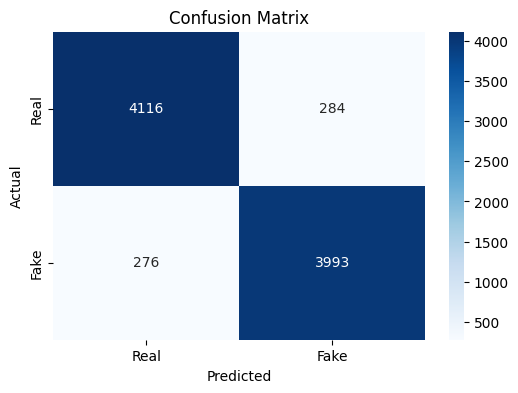

 ROC-AUC Score: 0.9768703017525926
Train Accuracy: 0.9507686095809419
Test Accuracy: 0.9354020071519207


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

best_logreg = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='lbfgs',
    class_weight=None,
    max_iter=1000,
    random_state=42
)

best_logreg.fit(X1_train, y_train)

y_pred = best_logreg.predict(X1_test)
y_proba = best_logreg.predict_proba(X1_test)[:, 1]

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_logreg.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


In [44]:
results_tracker = pd.DataFrame(columns=[
    'Model',
    'Vectorizer',
    'Train Accuracy',
    'Test Accuracy',
    'Precision (Fake)',
    'Recall (Fake)',
    'F1-Score (Fake)',
    'ROC-AUC'
])

In [45]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
results_tracker = pd.DataFrame(columns=[
    'Model', 'Vectorizer', 'Train Accuracy', 'Test Accuracy',
    'Precision (Fake)', 'Recall (Fake)', 'F1-Score (Fake)', 'ROC-AUC'
])

new_row = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_logreg.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)


,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769


#Decision Tree Classifier

Test Set Accuracy: 0.7901718768023993

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      4400
           1       0.79      0.78      0.79      4269

    accuracy                           0.79      8669
   macro avg       0.79      0.79      0.79      8669
weighted avg       0.79      0.79      0.79      8669



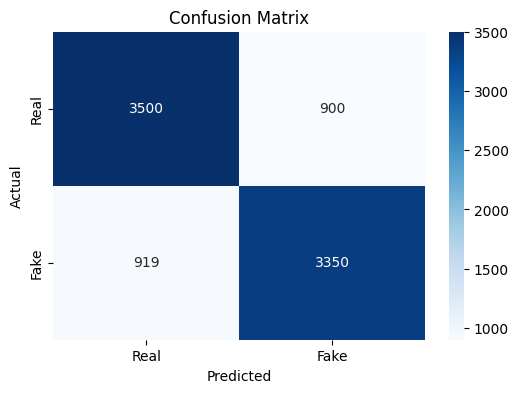

 ROC-AUC Score: 0.7382913019868396
Train Accuracy: 0.9920110748997779
Test Accuracy: 0.7901718768023993


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_dtree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

best_dtree.fit(X1_train, y_train)
y_pred = best_dtree.predict(X1_test)
y_proba = best_dtree.predict_proba(X1_test)[:, 1]


print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_dtree.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


In [47]:
new_row = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_dtree.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383


#Random Forest Classifier

Test Set Accuracy: 0.8664205790748645

 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      4400
           1       0.87      0.86      0.86      4269

    accuracy                           0.87      8669
   macro avg       0.87      0.87      0.87      8669
weighted avg       0.87      0.87      0.87      8669



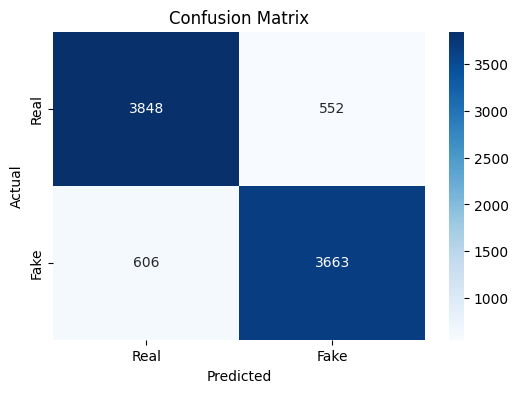

 ROC-AUC Score: 0.9439799346238208
Train Accuracy: 1.0
Test Accuracy: 0.8664205790748645


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


best_rf = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X1_train, y_train)

y_pred = best_rf.predict(X1_test)
y_proba = best_rf.predict_proba(X1_test)[:, 1]

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_rf.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [49]:
new_row = pd.DataFrame([{
    'Model': 'Random Forest',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_rf.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440


#Gradient Boosting Classifier

 Test Set Accuracy: 0.9070250317222286

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      4400
           1       0.90      0.91      0.91      4269

    accuracy                           0.91      8669
   macro avg       0.91      0.91      0.91      8669
weighted avg       0.91      0.91      0.91      8669



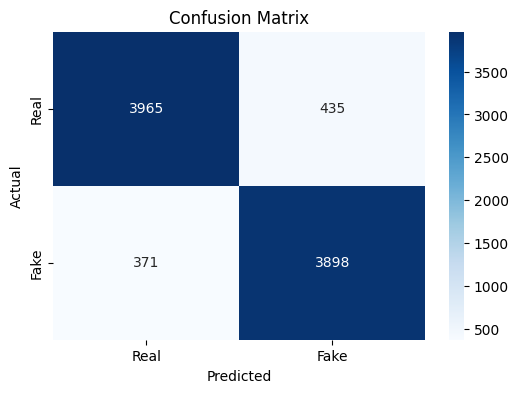

 ROC-AUC Score: 0.9687550309844758


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

best_gbm.fit(X1_train, y_train)

y_pred = best_gbm.predict(X1_test)
y_proba = best_gbm.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)

In [51]:
new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_gbm.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688


In [52]:
print("Train Accuracy:", best_gbm.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.9807342889279843
Test Accuracy: 0.9070250317222286


#XGBoost

In [53]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:12:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Test Set Accuracy: 0.9059868496943131

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      4400
           1       0.90      0.91      0.91      4269

    accuracy                           0.91      8669
   macro avg       0.91      0.91      0.91      8669
weighted avg       0.91      0.91      0.91      8669



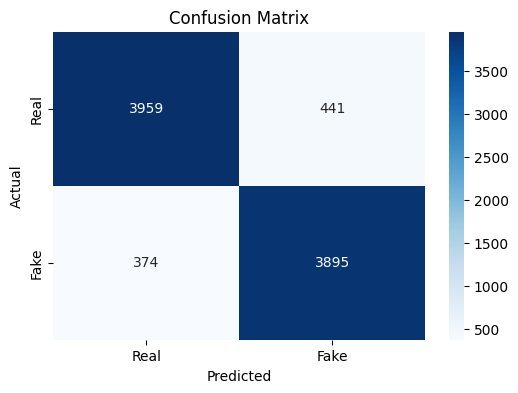

 ROC-AUC Score: 0.9681099469750208
Train Accuracy: 0.9788596314134917
Test Accuracy: 0.9059868496943131


In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X1_train, y_train)

y_pred = best_xgb.predict(X1_test)
y_proba = best_xgb.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_xgb.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [55]:
new_row = pd.DataFrame([{
    'Model': 'XGBoost',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_xgb.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681


#AdaBoost

 Test Set Accuracy: 0.8787634098511939

 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4400
           1       0.88      0.88      0.88      4269

    accuracy                           0.88      8669
   macro avg       0.88      0.88      0.88      8669
weighted avg       0.88      0.88      0.88      8669



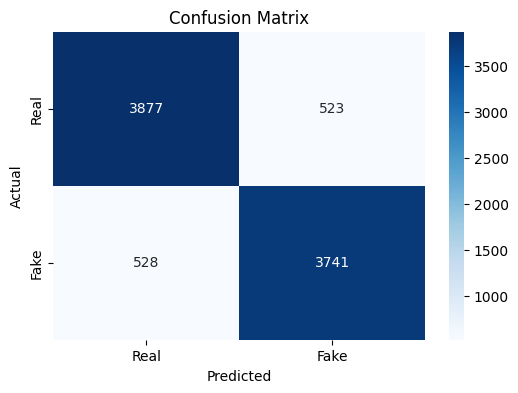

 ROC-AUC Score: 0.9490791967460976
Train Accuracy: 0.912352550976264
Test Accuracy: 0.8787634098511939


In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

best_ada.fit(X1_train, y_train)
y_pred = best_ada.predict(X1_test)
y_proba = best_ada.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_ada.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [57]:
new_row = pd.DataFrame([{
    'Model': 'AdaBoost',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_ada.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491


#LightGBM

In [58]:
!pip install lightgbm
X1_train = X1_train.astype('float32')
X1_test = X1_test.astype('float32')

[LightGBM] [Info] Number of positive: 17077, number of negative: 17596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244800
[LightGBM] [Info] Number of data points in the train set: 34673, number of used features: 960
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492516 -> initscore=-0.029939
[LightGBM] [Info] Start training from score -0.029939
 Test Set Accuracy: 0.9099088706886608

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      4400
           1       0.90      0.91      0.91      4269

    accuracy                           0.91      8669
   macro avg       0.91      0.91      0.91      8669
weighted avg       0.91      0.91      0.91      8669



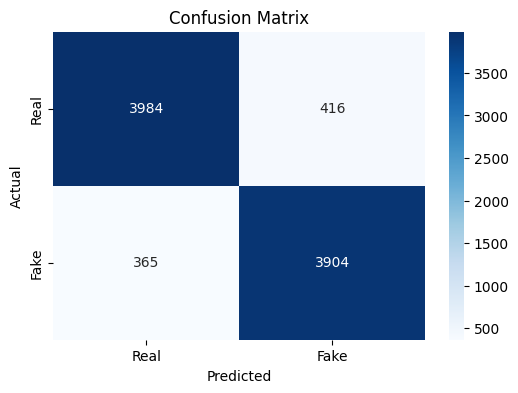

ROC-AUC Score: 0.9704614663855705
Train Accuracy: 0.9866755112046838
Test Accuracy: 0.9099088706886608


In [59]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    random_state=42
)

best_lgbm.fit(X1_train, y_train)
y_pred = best_lgbm.predict(X1_test)
y_proba = best_lgbm.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_lgbm.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [60]:
new_row = pd.DataFrame([{
    'Model': 'LightGBM',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_lgbm.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705


#CatBoost

In [61]:
!pip install catboost


Test Set Accuracy: 0.8968739185603876

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4400
           1       0.89      0.90      0.90      4269

    accuracy                           0.90      8669
   macro avg       0.90      0.90      0.90      8669
weighted avg       0.90      0.90      0.90      8669



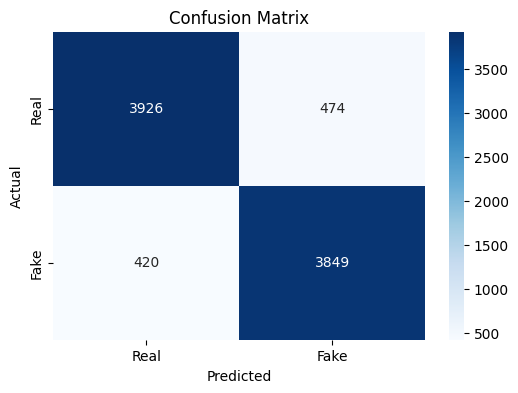

 ROC-AUC Score: 0.9623366127898806
Train Accuracy: 0.9289360597583134
Test Accuracy: 0.8968739185603876


In [62]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_catboost = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)

best_catboost.fit(X1_train, y_train)
y_pred = best_catboost.predict(X1_test)
y_proba = best_catboost.predict_proba(X1_test)[:, 1]

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_catboost.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [63]:
new_row = pd.DataFrame([{
    'Model': 'CatBoost',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_catboost.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623


#Linear SVM

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppr

 Test Set Accuracy: 0.9356327142692352

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4400
           1       0.93      0.94      0.94      4269

    accuracy                           0.94      8669
   macro avg       0.94      0.94      0.94      8669
weighted avg       0.94      0.94      0.94      8669



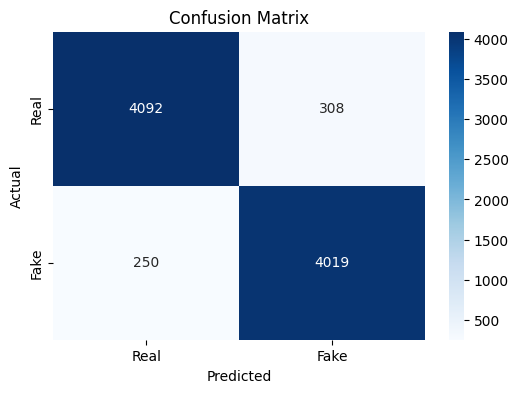

ROC-AUC Score: 0.9768905321663578
Train Accuracy: 0.9492112017996712
Test Accuracy: 0.9356327142692352


In [121]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

base_svm = LinearSVC(C=0.1, loss='squared_hinge', class_weight='balanced', max_iter=5000, random_state=42)
best_svm = CalibratedClassifierCV(base_svm, method='sigmoid')
best_svm.fit(X1_train, y_train)

y_pred = best_svm.predict(X1_test)
y_proba = best_svm.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_svm.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


In [122]:
new_row = pd.DataFrame([{
    'Model': 'SVM (Linear)',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_svm.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Bernoulli Naive Bayes

 Test Set Accuracy: 0.8442726958126658

 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4400
           1       0.83      0.85      0.84      4269

    accuracy                           0.84      8669
   macro avg       0.84      0.84      0.84      8669
weighted avg       0.84      0.84      0.84      8669



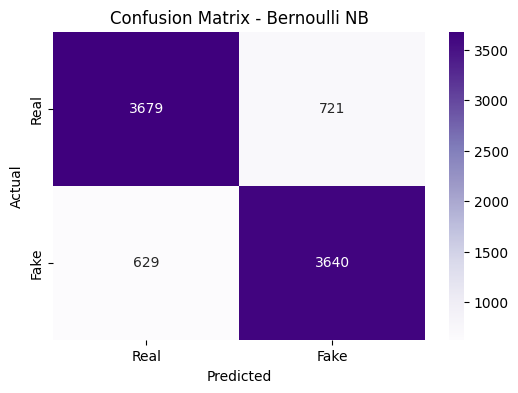

 ROC-AUC Score: 0.9246
Train Accuracy: 0.8496813082225363
Test Accuracy: 0.8442726958126658


In [123]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_bernoulli_nb = BernoulliNB(alpha=0.5, binarize=0.0)

best_bernoulli_nb.fit(X1_train, y_train)
y_pred = best_bernoulli_nb.predict(X1_test)
y_proba = best_bernoulli_nb.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix - Bernoulli NB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", round(roc_auc, 4))
print("Train Accuracy:", best_bernoulli_nb.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


In [124]:
new_row = pd.DataFrame([{
    'Model': 'Bernoulli Naive Bayes',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_bernoulli_nb.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Linear SVC

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Test Set Accuracy: 0.9357480678278924

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4400
           1       0.93      0.94      0.93      4269

    accuracy                           0.94      8669
   macro avg       0.94      0.94      0.94      8669
weighted avg       0.94      0.94      0.94      8669



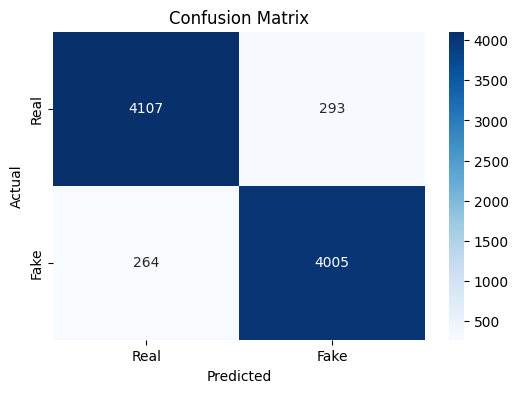

 ROC-AUC Score: 0.9765065269703359
Train Accuracy: 0.9494130879935396
Test Accuracy: 0.9357480678278924


In [125]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best_lsvc = LinearSVC(C=1.0, max_iter=5000, random_state=42)
best_lsvc.fit(X1_train, y_train)

y_pred = best_lsvc.predict(X1_test)
y_score = best_lsvc.decision_function(X1_test)

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_score)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_lsvc.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [126]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'LinearSVC',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_lsvc.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)


,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#PassiveAggressiveClassifier

 Test Set Accuracy: 0.9009112931133926

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      4400
           1       0.88      0.93      0.90      4269

    accuracy                           0.90      8669
   macro avg       0.90      0.90      0.90      8669
weighted avg       0.90      0.90      0.90      8669



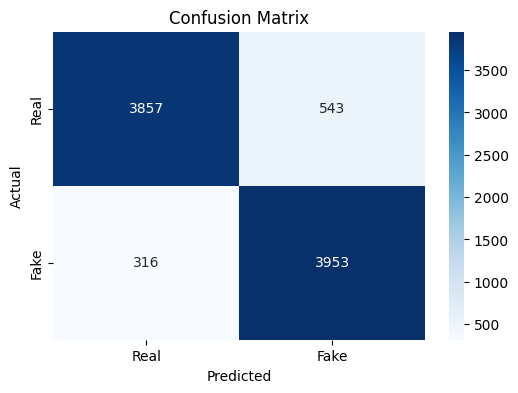

 ROC-AUC Score: 0.9511405694329095
Train Accuracy: 0.912439073630779
Test Accuracy: 0.9009112931133926


In [127]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


best_pac = PassiveAggressiveClassifier(C=1.0, loss='hinge', max_iter=1000, random_state=42)
best_pac.fit(X1_train, y_train)
y_pred = best_pac.predict(X1_test)
y_proba = best_pac.decision_function(X1_test)

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.metrics import roc_auc_score
print(" ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Train Accuracy:", best_pac.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [128]:
new_row = pd.DataFrame([{
    'Model': 'Passive Aggressive',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_pac.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#SGDClassifier

 Test Set Accuracy: 0.9359787749452071

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4400
           1       0.93      0.94      0.94      4269

    accuracy                           0.94      8669
   macro avg       0.94      0.94      0.94      8669
weighted avg       0.94      0.94      0.94      8669



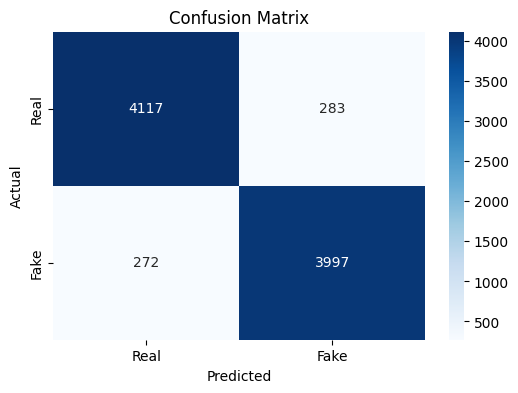

 ROC-AUC Score: 0.9765268638599628
Train Accuracy: 0.9509993366596488
Test Accuracy: 0.9359787749452071


In [129]:
from sklearn.linear_model import SGDClassifier

best_sgd = SGDClassifier(
    loss='hinge',
    alpha=0.001,
    penalty='l2',
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

best_sgd.fit(X1_train, y_train)
y_pred = best_sgd.predict(X1_test)
y_proba = best_sgd.decision_function(X1_test)

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", best_sgd.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [130]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'SGDClassifier',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_sgd.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Ridge Classifier

 Test Set Accuracy: 0.9324028146268313

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      4400
           1       0.92      0.94      0.93      4269

    accuracy                           0.93      8669
   macro avg       0.93      0.93      0.93      8669
weighted avg       0.93      0.93      0.93      8669



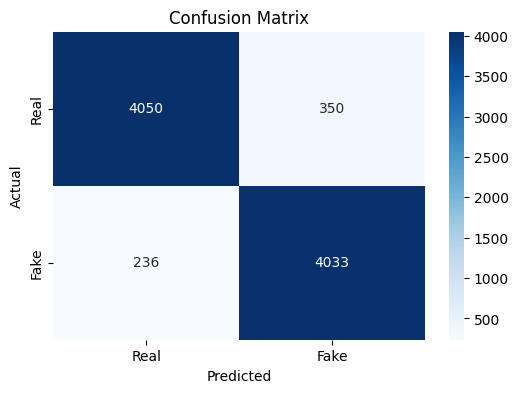

 ROC-AUC Score: 0.9744004344215167
 Ridge Classifier Results
Train Accuracy: 0.9367519395495054
Test Accuracy: 0.9324028146268313


In [131]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import RidgeClassifier

best_ridge = RidgeClassifier(alpha=1.0, solver='auto')
best_ridge.fit(X1_train, y_train)
y_pred = best_ridge.predict(X1_test)
y_proba = best_ridge.decision_function(X1_test)

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print(" Ridge Classifier Results")
print("Train Accuracy:", accuracy_score(y_train, best_ridge.predict(X1_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [132]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'RidgeClassifier',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(best_ridge.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Bagging Classifier

In [133]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
base_estimator = DecisionTreeClassifier(max_depth=10, random_state=42)

bagging_clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=50,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


 Test Set Accuracy: 0.8566155265889953

 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      4400
           1       0.84      0.88      0.86      4269

    accuracy                           0.86      8669
   macro avg       0.86      0.86      0.86      8669
weighted avg       0.86      0.86      0.86      8669



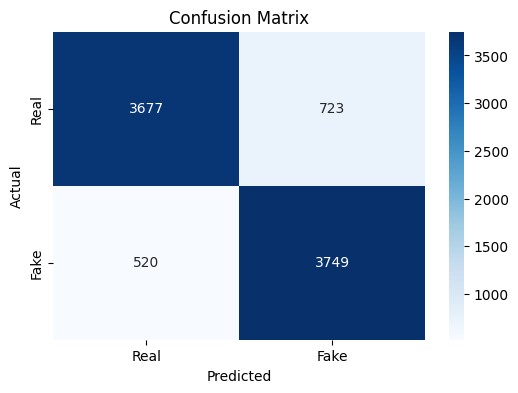

 ROC-AUC Score: 0.9290524446857896
 Train Accuracy: 0.926571107201569
 Test Accuracy: 0.8566155265889953


In [134]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
bagging_clf.fit(X1_train, y_train)

y_pred = bagging_clf.predict(X1_test)
y_proba = bagging_clf.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print(" Train Accuracy:", bagging_clf.score(X1_train, y_train))
print(" Test Accuracy:", accuracy_score(y_test, y_pred))

In [135]:
from sklearn.metrics import precision_score, recall_score, f1_score

new_row = pd.DataFrame([{
    'Model': 'Bagging Classifier',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(bagging_clf.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(precision_score(y_test, y_pred), 4),
    'Recall (Fake)': round(recall_score(y_test, y_pred), 4),
    'F1-Score (Fake)': round(f1_score(y_test, y_pred), 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#StackingClassifier

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` 

 Test Set Accuracy: 0.936324835621179

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4400
           1       0.93      0.94      0.94      4269

    accuracy                           0.94      8669
   macro avg       0.94      0.94      0.94      8669
weighted avg       0.94      0.94      0.94      8669



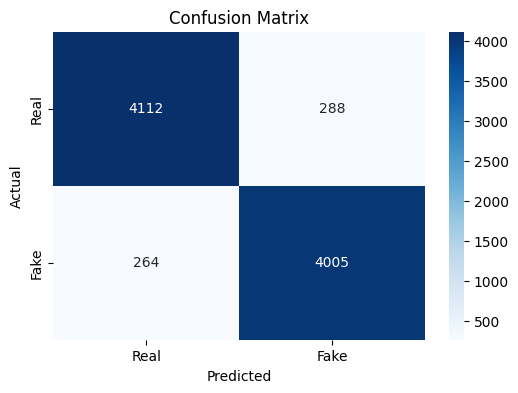

ROC-AUC Score: 0.9821709895866608
Train Accuracy: 0.9791191993770368
Test Accuracy: 0.936324835621179


In [136]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

base_estimators = [
    ('lr', LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)),
    ('svc', LinearSVC(C=1.0, max_iter=1000))
]

final_estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,
    cv=5,
    n_jobs=-1
)

stack_clf.fit(X1_train, y_train)

y_pred = stack_clf.predict(X1_test)

try:
    y_proba = stack_clf.predict_proba(X1_test)[:, 1]
except:
    y_proba = y_pred

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)
print("Train Accuracy:", stack_clf.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [137]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'Stacking Classifier',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(stack_clf.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Hard Voting Classifier

 Test Set Accuracy: 0.8959510900911293

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      4400
           1       0.89      0.89      0.89      4269

    accuracy                           0.90      8669
   macro avg       0.90      0.90      0.90      8669
weighted avg       0.90      0.90      0.90      8669



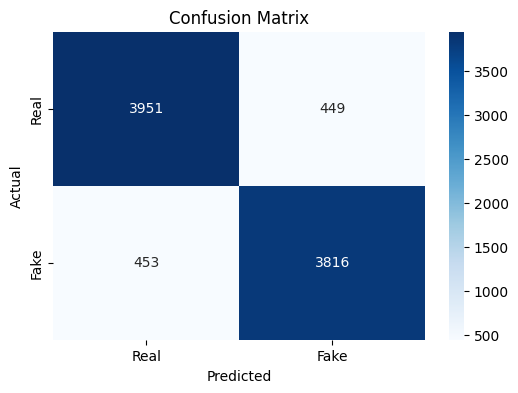

 ROC-AUC Score: 0.8959203507314892
Train Accuracy: 0.9713321604706833
Test Accuracy: 0.8959510900911293


In [138]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
voting_estimators = [
    ('lr', LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3))
]

voting_hard = VotingClassifier(estimators=voting_estimators, voting='hard', n_jobs=-1)
voting_hard.fit(X1_train, y_train)
y_pred = voting_hard.predict(X1_test)
y_proba = y_pred

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

try:
    roc_auc = roc_auc_score(y_test, y_proba)
except:
    roc_auc = 0.0
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", voting_hard.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [139]:
report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'Voting Classifier (Hard)',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(voting_hard.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)


,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Soft Voting Classifier

 Test Set Accuracy: 0.9283654400738263

 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4400
           1       0.93      0.93      0.93      4269

    accuracy                           0.93      8669
   macro avg       0.93      0.93      0.93      8669
weighted avg       0.93      0.93      0.93      8669



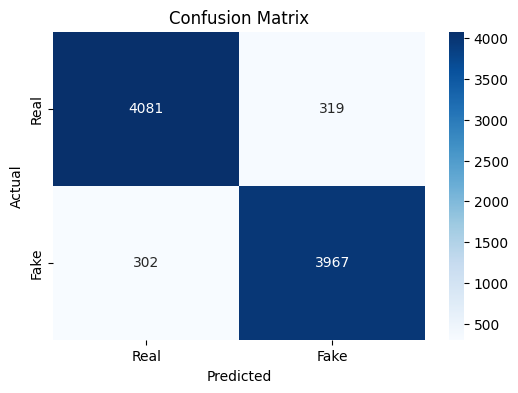

 ROC-AUC Score: 0.9770852232798823
Train Accuracy: 0.9738413174516194
Test Accuracy: 0.9283654400738263


In [140]:
voting_estimators_soft = [
    ('lr', LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3))
]

voting_soft = VotingClassifier(estimators=voting_estimators_soft, voting='soft', n_jobs=-1)

voting_soft.fit(X1_train, y_train)
y_pred = voting_soft.predict(X1_test)
y_proba = voting_soft.predict_proba(X1_test)[:, 1]

print(" Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy:", voting_soft.score(X1_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [141]:
report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'Voting Classifier (Soft)',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(voting_soft.score(X1_train, y_train), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#Feedforward Neural Network

In [142]:
!pip install tensorflow


In [143]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
print("TensorFlow version:", tf.__version__)

2025-08-12 22:27:01.346520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 22:27:01.825952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755037622.000153    4294 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755037622.049922    4294 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755037622.435543    4294 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-12 22:27:06.807647: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8744 - loss: 0.3286 - val_accuracy: 0.9317 - val_loss: 0.1823
Epoch 2/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9365 - loss: 0.1784 - val_accuracy: 0.9363 - val_loss: 0.1694
Epoch 3/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9479 - loss: 0.1457 - val_accuracy: 0.9357 - val_loss: 0.1670
Epoch 4/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9575 - loss: 0.1202 - val_accuracy: 0.9406 - val_loss: 0.1625
Epoch 5/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9611 - loss: 0.1083 - val_accuracy: 0.9400 - val_loss: 0.1707
Epoch 6/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9667 - loss: 0.0931 - val_accuracy: 0.9392 - val_loss: 0.1723
Epoch 7/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9716 - loss: 0.0798 - val_accuracy: 0.9406 - val_loss: 0.1827
Epoch 8/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9764 - loss: 0.0696 - val_accuracy: 0.

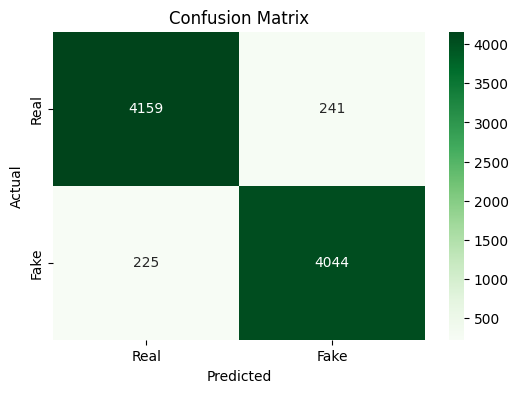

 ROC-AUC Score: 0.9854417683511147
Train Accuracy (last epoch): 0.9807
Test Accuracy: 0.9462


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
model_nn = Sequential([
    Dense(128, activation='relu', input_dim=X1_train.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X1_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
y_proba = model_nn.predict(X1_test).flatten()
y_pred = (y_proba >= 0.5).astype(int)

print(" Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(" ROC-AUC Score:", roc_auc)
print("Train Accuracy (last epoch):", round(history.history['accuracy'][-1], 4))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))

In [145]:
report = classification_report(y_test, y_pred, output_dict=True)

new_row = pd.DataFrame([{
    'Model': 'Neural Network (FFNN)',
    'Vectorizer': 'Bag of Words',
    'Train Accuracy': round(history.history['accuracy'][-1], 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(report['1']['precision'], 4),
    'Recall (Fake)': round(report['1']['recall'], 4),
    'F1-Score (Fake)': round(report['1']['f1-score'], 4),
    'ROC-AUC': round(roc_auc, 4)
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)

,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC
0,Logistic Regression,Bag of Words,0.9508,0.9354,0.9336,0.9353,0.9345,0.9769
1,Decision Tree,Bag of Words,0.9920,0.7902,0.7882,0.7847,0.7865,0.7383
2,Random Forest,Bag of Words,1.0000,0.8664,0.8690,0.8580,0.8635,0.9440
3,Gradient Boosting,Bag of Words,0.9807,0.9070,0.8996,0.9131,0.9063,0.9688
4,XGBoost,Bag of Words,0.9789,0.9060,0.8983,0.9124,0.9053,0.9681
5,AdaBoost,Bag of Words,0.9124,0.8788,0.8773,0.8763,0.8768,0.9491
6,LightGBM,Bag of Words,0.9867,0.9099,0.9037,0.9145,0.9091,0.9705
7,CatBoost,Bag of Words,0.9289,0.8969,0.8904,0.9016,0.8959,0.9623
8,SVM (Linear),Bag of Words,0.9492,0.9356,0.9288,0.9414,0.9351,0.9769
9,Bernoulli Naive Bayes,Bag of Words,0.8497,0.8443,0.8347,0.8527,0.8436,0.9246


#CNN
Code block for CNN neural network model to be used when run with specific vectorizers

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df_subset['joined_text'] = df_subset['tokens'].apply(lambda x: ' '.join(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_subset['joined_text'])

sequences = tokenizer.texts_to_sequences(df_subset['joined_text'])
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X1_train, X1_test, y_train, y_test = train_test_split(
    padded_sequences, df_subset['label'], test_size=0.2, stratify=df_subset['label'], random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

cnn_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix],
              input_length=X1_train.shape[1],
              trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(X1_train, y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.1,
                        callbacks=[early_stop],
                        verbose=1)


In [ ]:
y_proba = cnn_model.predict(X1_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(" Test Set Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = round(roc_auc_score(y_test, y_proba), 4)
print(" ROC-AUC Score:", roc_auc)


In [ ]:
new_row = pd.DataFrame([{
    'Model': 'CNN',
    'Vectorizer': 'GloVe',
    'Train Accuracy': round(history.history['accuracy'][-1], 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': roc_auc
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)


#LSTM
Code block for LSTM to be run when required with specific vectorizers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

lstm_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix],
              input_length=X1_train.shape[1],
              trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X1_train, y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.1,
                         callbacks=[early_stop],
                         verbose=1)


In [ ]:
y_proba = lstm_model.predict(X1_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(" Test Set Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix (LSTM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = round(roc_auc_score(y_test, y_proba), 4)
print(" ROC-AUC Score:", roc_auc)

In [ ]:
new_row = pd.DataFrame([{
    'Model': 'LSTM',
    'Vectorizer': 'GloVe',
    'Train Accuracy': round(history.history['accuracy'][-1], 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
    'Precision (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
    'Recall (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
    'F1-Score (Fake)': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
    'ROC-AUC': roc_auc
}])

results_tracker = pd.concat([results_tracker, new_row], ignore_index=True)
display(results_tracker)


#Final Result Analysis

In [82]:
df_results = pd.read_csv("results_master.csv")
df_results.head()
df_bow = df_results[df_results['Vectorizer'] == 'Bag of Words']
df_bow

# Remove rows where Vectorizer is Bag of Words or TF-IDF without dimensionality reduction
df_no_bow_tfidf = df_results[~df_results['Vectorizer'].isin(['Bag of Words', 'TF-IDF'])].reset_index(drop=True)
print(df_no_bow_tfidf.shape)
df_no_bow_tfidf['Vectorizer'].value_counts()
df = df_no_bow_tfidf
df.head()

(154, 9)


,Model,Vectorizer,Train Accuracy,Test Accuracy,Precision (Fake),Recall (Fake),F1-Score (Fake),ROC-AUC,PCA
0,Logistic Regression,GloVe-100,0.8276,0.8301,0.8242,0.8325,0.8283,0.9029,No
1,Decision Tree,GloVe-100,0.994,0.7353,0.7235,0.7728,0.7291,0.7087,No
2,Random Forest,GloVe-100,1,0.8415,0.8283,0.8555,0.8417,0.9217,No
3,Gradient Boosting,GloVe-100,0.9318,0.8654,0.8620,0.8651,0.8636,0.9381,No
4,XGBoost,GloVe-100,0.9295,0.8699,0.8642,0.8687,0.8665,0.9407,No


In [83]:
# Number of unique models
print("Number of unique models")
n_models = df['Model'].nunique()
print(n_models)
#  Number of unique vectorizers
print("Number of unique vectorizers")
n_vectorizers = df['Vectorizer'].nunique()
print(n_vectorizers)

Number of unique models
21
Number of unique vectorizers
8


In [84]:
# Top 5 best performing vectorizers by Test Accuracy
print("Top 5 best performing vectorizers by Test Accuracy")
best_vectorizers = (
    df.groupby('Vectorizer', as_index=False)['Test Accuracy']
      .mean()
      .sort_values('Test Accuracy', ascending=False)
      .head(5)
)
print(best_vectorizers.to_string(index=False))

Top 5 best performing vectorizers by Test Accuracy
Vectorizer  Test Accuracy
    DR-BoW       0.901768
  DR-TFIDF       0.888947
      BERT       0.879268
   Doc2Vec       0.870395
  Word2Vec       0.864205


/var/tmp/ipykernel_4294/2949285711.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


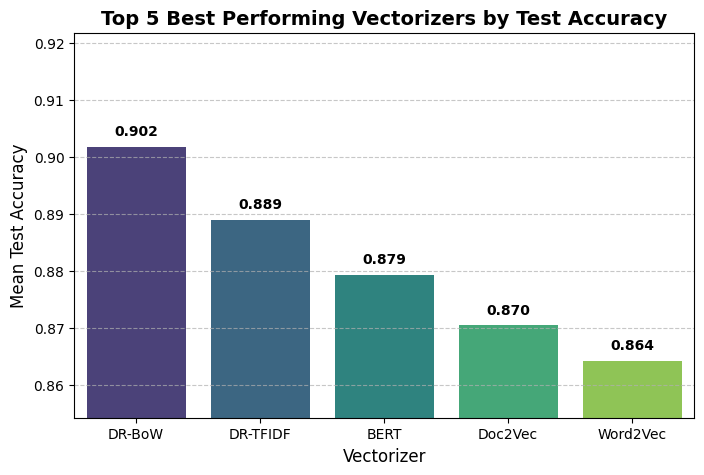

In [85]:
# Visualization for Top 5 Best Performing Vectorizers by Test Accuracy

plt.figure(figsize=(8, 5))
sns.barplot(
    data=best_vectorizers.reset_index(),
    x='Vectorizer',
    y='Test Accuracy',
    palette='viridis'
)

for i, val in enumerate(best_vectorizers['Test Accuracy']):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(best_vectorizers['Test Accuracy'].min() - 0.01, best_vectorizers['Test Accuracy'].max() + 0.02)
plt.title("Top 5 Best Performing Vectorizers by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Mean Test Accuracy", fontsize=12)
plt.xlabel("Vectorizer", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [86]:
# Top 5 worst performing vectorizers by Test Accuracy
print("Top 5 worst performing vectorizers by Test Accuracy")
worst_vectorizers = (
    df.groupby('Vectorizer', as_index=False)['Test Accuracy']
      .mean()
      .sort_values('Test Accuracy', ascending=True)
      .head(5)
)
print(worst_vectorizers.to_string(index=False))

Top 5 worst performing vectorizers by Test Accuracy
Vectorizer  Test Accuracy
 GloVe-200       0.829358
 GloVe-100       0.829389
 GloVe-300       0.853971
  Word2Vec       0.864205
   Doc2Vec       0.870395


/var/tmp/ipykernel_4294/3104945604.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


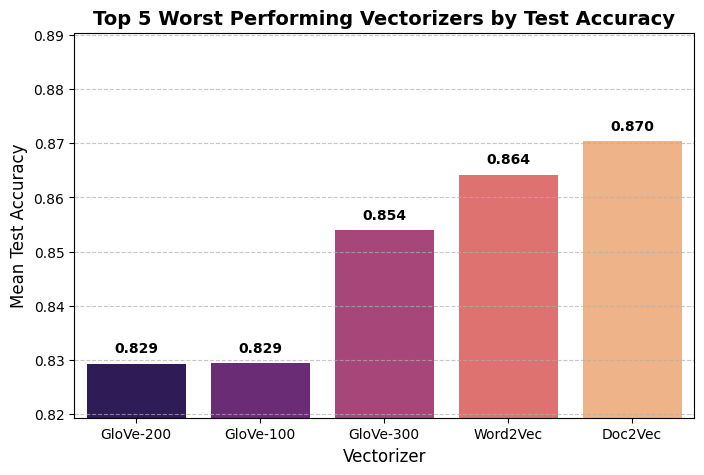

In [87]:
# Visualization for Top 5 Worst Performing Vectorizers by Test Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=worst_vectorizers.reset_index(),
    x='Vectorizer',
    y='Test Accuracy',
    palette='magma'
)

for i, val in enumerate(worst_vectorizers['Test Accuracy']):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(worst_vectorizers['Test Accuracy'].min() - 0.01, worst_vectorizers['Test Accuracy'].max() + 0.02)
plt.title("Top 5 Worst Performing Vectorizers by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Mean Test Accuracy", fontsize=12)
plt.xlabel("Vectorizer", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [88]:
# Top 5 best performing models by Test Accuracy
print("Top 5 best performing models by Test Accuracy")
best_models = (
    df.groupby('Model', as_index=False)['Test Accuracy']
      .mean()
      .sort_values('Test Accuracy', ascending=False)
      .head(5)
)
print(best_models.to_string(index=False))

Top 5 best performing models by Test Accuracy
                Model  Test Accuracy
                 LSTM       0.927600
Neural Network (FFNN)       0.903175
                  CNN       0.897500
  Stacking Classifier       0.894925
             LightGBM       0.890988


/var/tmp/ipykernel_4294/3609055604.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


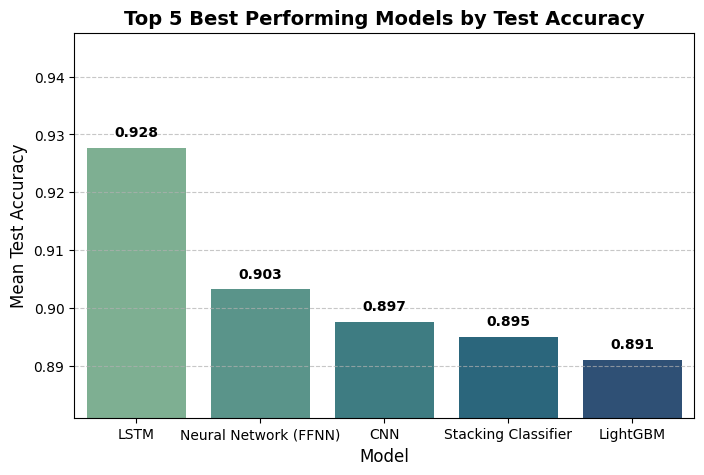

In [89]:
# Visualization for Top 5 Best Performing Models by Test Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=best_models.reset_index(),
    x='Model',
    y='Test Accuracy',
    palette='crest'
)

for i, val in enumerate(best_models['Test Accuracy']):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(best_models['Test Accuracy'].min() - 0.01, best_models['Test Accuracy'].max() + 0.02)
plt.title("Top 5 Best Performing Models by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Mean Test Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [90]:
# Top 5 worst performing models by Test Accuracy
print("Top 5 worst performing models by Test Accuracy")
worst_models = (
    df.groupby('Model', as_index=False)['Test Accuracy']
      .mean()
      .sort_values('Test Accuracy', ascending=True)
      .head(5)
)
print(worst_models.to_string(index=False))

Top 5 worst performing models by Test Accuracy
                Model  Test Accuracy
        Decision Tree       0.750800
Bernoulli Naive Bayes       0.788312
   Bagging Classifier       0.834987
   Passive Aggressive       0.843225
             AdaBoost       0.851363


/var/tmp/ipykernel_4294/2096598571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


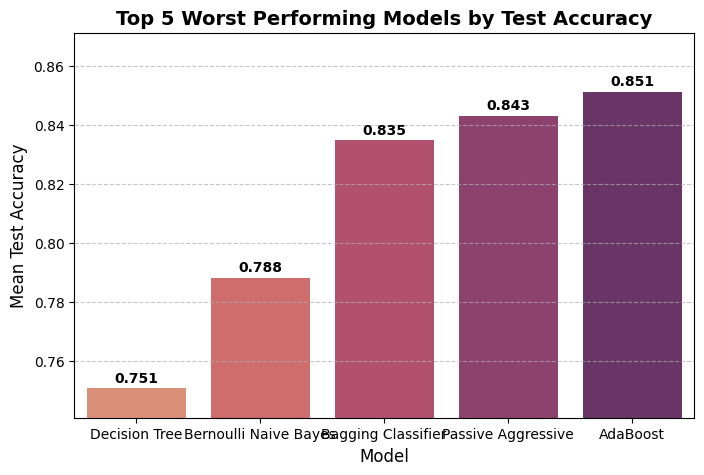

In [91]:
# Visualization for Top 5 Worst Performing Models by Test Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

worst_models = (
    df.groupby('Model', as_index=False)['Test Accuracy']
      .mean()
      .sort_values('Test Accuracy', ascending=True)
      .head(5)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=worst_models.reset_index(),
    x='Model',
    y='Test Accuracy',
    palette='flare'
)

for i, val in enumerate(worst_models['Test Accuracy']):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(worst_models['Test Accuracy'].min() - 0.01, worst_models['Test Accuracy'].max() + 0.02)
plt.title("Top 5 Worst Performing Models by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Mean Test Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [92]:
#  Best performing row by Test Accuracy
print("Best performing row by Test Accuracy (entire row)")
row = df.loc[df['Test Accuracy'].idxmax()]
print(row.to_string())


Best performing row by Test Accuracy (entire row)
Model               Neural Network (FFNN)
Vectorizer                         DR-BoW
Train Accuracy                     0.9784
Test Accuracy                      0.9431
Precision (Fake)                   0.9442
Recall (Fake)                        0.94
F1-Score (Fake)                    0.9421
ROC-AUC                            0.9858
PCA                                   Yes


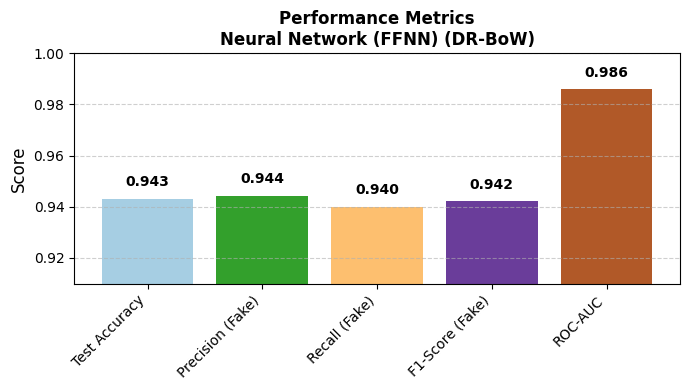

In [93]:
metric_names = ["Test Accuracy", "Precision (Fake)", "Recall (Fake)", "F1-Score (Fake)", "ROC-AUC"]
metric_vals = [float(row[m]) for m in metric_names]

ymin = max(0.0, min(metric_vals) - 0.03)
ymax = min(1.0, max(metric_vals) + 0.02)
colors = plt.cm.Paired(np.linspace(0, 1, len(metric_vals)))
plt.figure(figsize=(7, 4))
bars = plt.bar(metric_names, metric_vals, color=colors)

for b, v in zip(bars, metric_vals):
    plt.text(b.get_x() + b.get_width()/2, v + 0.005, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(ymin, ymax)
plt.title(f"Performance Metrics\n{row['Model']} ({row['Vectorizer']})", fontsize=12, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [94]:
print("Worst performing row by Test Accuracy (entire row)")
row = df.loc[df['Test Accuracy'].idxmin()]
print(row.to_string())


Worst performing row by Test Accuracy (entire row)
Model               Decision Tree
Vectorizer                Doc2Vec
Train Accuracy             0.9933
Test Accuracy              0.6688
Precision (Fake)           0.6646
Recall (Fake)               0.661
F1-Score (Fake)            0.6628
ROC-AUC                    0.6279
PCA                            No


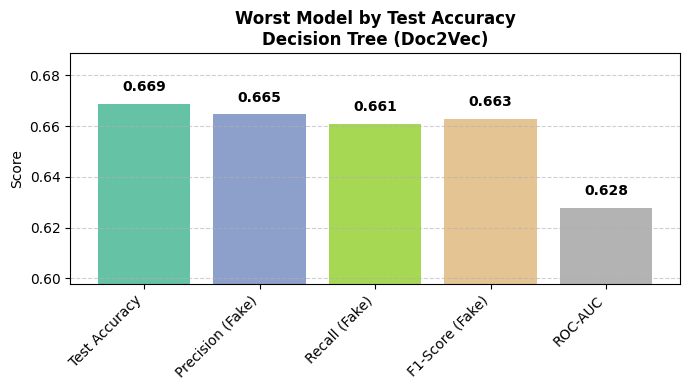

In [95]:
row_worst_acc = df.loc[pd.to_numeric(df['Test Accuracy'], errors='coerce').idxmin()]

metric_names = ["Test Accuracy", "Precision (Fake)", "Recall (Fake)", "F1-Score (Fake)", "ROC-AUC"]
metric_vals = [float(row_worst_acc[m]) for m in metric_names]

ymin = max(0.0, min(metric_vals) - 0.03)
ymax = min(1.0, max(metric_vals) + 0.02)
colors = plt.cm.Set2(np.linspace(0, 1, len(metric_vals)))

plt.figure(figsize=(7, 4))
bars = plt.bar(metric_names, metric_vals, color=colors)

for b, v in zip(bars, metric_vals):
    plt.text(b.get_x() + b.get_width()/2, v + 0.005, f"{v:.3f}",
             ha='center', fontsize=10, fontweight='bold')

plt.ylim(ymin, ymax)
plt.title(f"Worst Model by Test Accuracy\n{row_worst_acc['Model']} ({row_worst_acc['Vectorizer']})",
          fontsize=12, fontweight='bold')
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

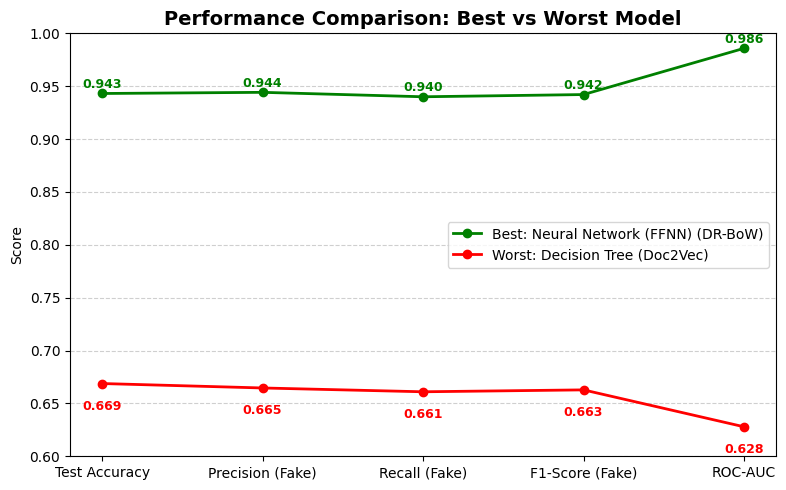

In [96]:
#Comparison of best and worst performing models line plot
row_best_acc = df.loc[pd.to_numeric(df['Test Accuracy'], errors='coerce').idxmax()]
row_worst_acc = df.loc[pd.to_numeric(df['Test Accuracy'], errors='coerce').idxmin()]
metric_names = ["Test Accuracy", "Precision (Fake)", "Recall (Fake)", "F1-Score (Fake)", "ROC-AUC"]
best_vals = [float(row_best_acc[m]) for m in metric_names]
worst_vals = [float(row_worst_acc[m]) for m in metric_names]
plt.figure(figsize=(8, 5))
plt.plot(metric_names, best_vals, marker='o', label=f"Best: {row_best_acc['Model']} ({row_best_acc['Vectorizer']})", color='green', linewidth=2)
plt.plot(metric_names, worst_vals, marker='o', label=f"Worst: {row_worst_acc['Model']} ({row_worst_acc['Vectorizer']})", color='red', linewidth=2)

for i, val in enumerate(best_vals):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center', fontsize=9, fontweight='bold', color='green')
for i, val in enumerate(worst_vals):
    plt.text(i, val - 0.025, f"{val:.3f}", ha='center', fontsize=9, fontweight='bold', color='red')

plt.ylim(0.6, 1.0)
plt.title("Performance Comparison: Best vs Worst Model", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
# 9) Top 5 best performing rows by Test Accuracy
print("Top 5 best performing rows by Test Accuracy (entire rows)")
print(
    df.sort_values('Test Accuracy', ascending=False)
      .head(5)
      .to_string(index=False)
)

Top 5 best performing rows by Test Accuracy (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
  Stacking Classifier     DR-BoW         0.9758         0.9360            0.9327         0.9377           0.9352   0.9822 Yes
        SGDClassifier     DR-BoW          0.951         0.9360            0.9339         0.9363           0.9351   0.9765 Yes
            LinearSVC     DR-BoW         0.9494         0.9357            0.9318         0.9382           0.9350   0.9765 Yes
         SVM (Linear)     DR-BoW         0.9492         0.9356            0.9288         0.9414           0.9351   0.9769 Yes


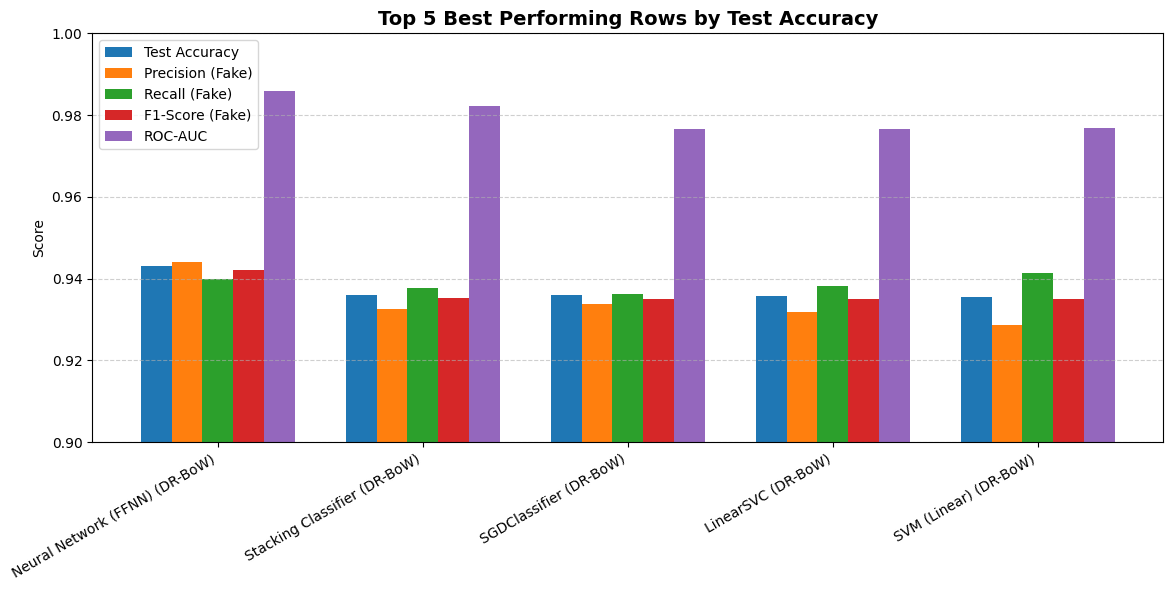

In [98]:
import matplotlib.pyplot as plt
import numpy as np

top5 = df.sort_values('Test Accuracy', ascending=False).head(5)

metrics = ["Test Accuracy", "Precision (Fake)", "Recall (Fake)", "F1-Score (Fake)", "ROC-AUC"]

x = np.arange(len(top5))
bar_width = 0.15

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, top5[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * (len(metrics)-1) / 2,
           [f"{m} ({v})" for m, v in zip(top5['Model'], top5['Vectorizer'])],
           rotation=30, ha='right', fontsize=10)
plt.ylabel("Score")
plt.title("Top 5 Best Performing Rows by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylim(0.9, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [99]:
# 10) Top 5 worst performing rows by Test Accuracy (entire rows)
print("Top 5 worst performing rows by Test Accuracy (entire rows)")
print(
    df.sort_values('Test Accuracy', ascending=True)
      .head(5)
      .to_string(index=False)
)

Top 5 worst performing rows by Test Accuracy (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
        Decision Tree    Doc2Vec         0.9933         0.6688            0.6646         0.6610           0.6628   0.6279  No
        Decision Tree  GloVe-300         0.9944         0.7288            0.7291         0.7149           0.7219   0.6908  No
        Decision Tree  GloVe-100          0.994         0.7353            0.7235         0.7728           0.7291   0.7087  No
        Decision Tree  GloVe-200          0.994         0.7353            0.7348         0.7236           0.7291   0.7087  No
Bernoulli Naive Bayes  GloVe-200         0.7452         0.7416            0.7462         0.7203           0.7330   0.8153  No


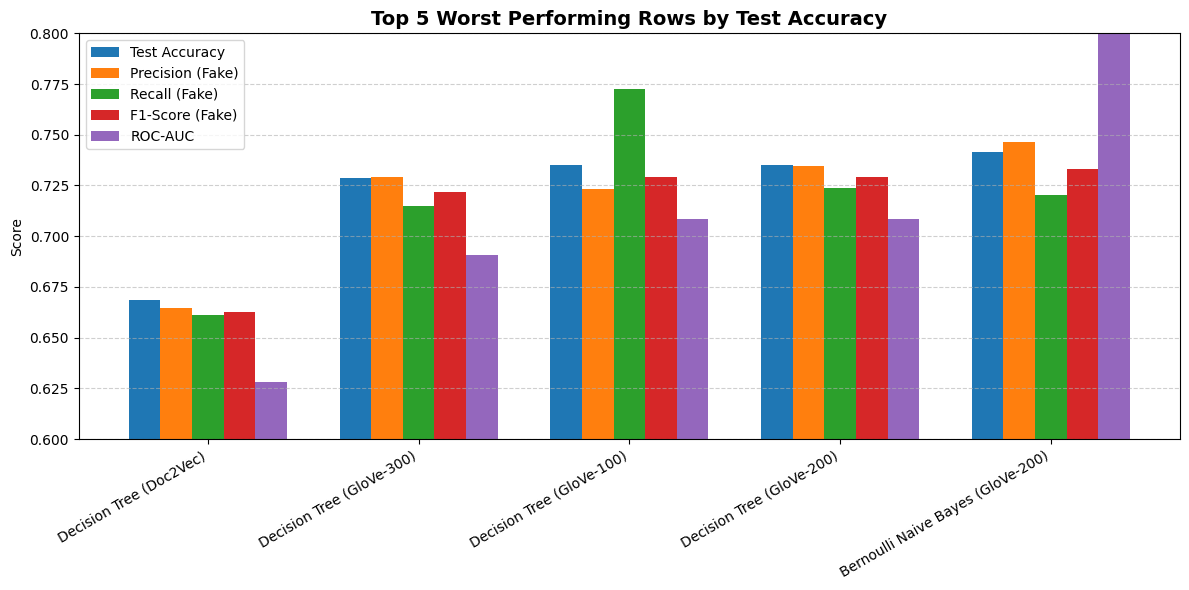

In [100]:
worst5 = df.sort_values('Test Accuracy', ascending=True).head(5)

metrics = ["Test Accuracy", "Precision (Fake)", "Recall (Fake)", "F1-Score (Fake)", "ROC-AUC"]
x = np.arange(len(worst5))
bar_width = 0.15

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, worst5[metric], width=bar_width, label=metric)


plt.xticks(x + bar_width * (len(metrics)-1) / 2,
           [f"{m} ({v})" for m, v in zip(worst5['Model'], worst5['Vectorizer'])],
           rotation=30, ha='right', fontsize=10)
plt.ylabel("Score")
plt.title("Top 5 Worst Performing Rows by Test Accuracy", fontsize=14, fontweight='bold')
plt.ylim(0.6, 0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [101]:
# Best performing row by F1-Score (Fake)
print("Best performing row by F1-Score (Fake) (entire row)")
row = df.loc[df['F1-Score (Fake)'].idxmax()]
print(row.to_string())


Best performing row by F1-Score (Fake) (entire row)
Model               Neural Network (FFNN)
Vectorizer                         DR-BoW
Train Accuracy                     0.9784
Test Accuracy                      0.9431
Precision (Fake)                   0.9442
Recall (Fake)                        0.94
F1-Score (Fake)                    0.9421
ROC-AUC                            0.9858
PCA                                   Yes


In [102]:
# Worst performing row by F1-Score (Fake)
print("Worst performing row by F1-Score (Fake) (entire row)")
row = df.loc[df['F1-Score (Fake)'].idxmin()]
print(row.to_string())

Worst performing row by F1-Score (Fake) (entire row)
Model               Decision Tree
Vectorizer                Doc2Vec
Train Accuracy             0.9933
Test Accuracy              0.6688
Precision (Fake)           0.6646
Recall (Fake)               0.661
F1-Score (Fake)            0.6628
ROC-AUC                    0.6279
PCA                            No


In [103]:
#  Top 5 best performing rows by F1-Score (Fake)
print("Top 5 best performing rows by F1-Score (Fake) (entire rows)")
print(
    df.sort_values('F1-Score (Fake)', ascending=False)
      .head(5)
      .to_string(index=False)
)

Top 5 best performing rows by F1-Score (Fake) (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
  Stacking Classifier     DR-BoW         0.9758         0.9360            0.9327         0.9377           0.9352   0.9822 Yes
        SGDClassifier     DR-BoW          0.951         0.9360            0.9339         0.9363           0.9351   0.9765 Yes
         SVM (Linear)     DR-BoW         0.9492         0.9356            0.9288         0.9414           0.9351   0.9769 Yes
            LinearSVC     DR-BoW         0.9494         0.9357            0.9318         0.9382           0.9350   0.9765 Yes


In [104]:
# Top 5 worst performing rows by F1-Score (Fake)
print("Top 5 worst performing rows by F1-Score (Fake) (entire rows)")
print(
    df.sort_values('F1-Score (Fake)', ascending=True)
      .head(5)
      .to_string(index=False)
)


Top 5 worst performing rows by F1-Score (Fake) (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
        Decision Tree    Doc2Vec         0.9933         0.6688            0.6646         0.6610           0.6628   0.6279  No
        Decision Tree  GloVe-300         0.9944         0.7288            0.7291         0.7149           0.7219   0.6908  No
        Decision Tree  GloVe-100          0.994         0.7353            0.7235         0.7728           0.7291   0.7087  No
        Decision Tree  GloVe-200          0.994         0.7353            0.7348         0.7236           0.7291   0.7087  No
Bernoulli Naive Bayes  GloVe-200         0.7452         0.7416            0.7462         0.7203           0.7330   0.8153  No


In [105]:
# Best performing row by ROC-AUC
print("Best performing row by ROC-AUC (entire row)")
row = df.loc[df['ROC-AUC'].idxmax()]
print(row.to_string())


Best performing row by ROC-AUC (entire row)
Model               Neural Network (FFNN)
Vectorizer                         DR-BoW
Train Accuracy                     0.9784
Test Accuracy                      0.9431
Precision (Fake)                   0.9442
Recall (Fake)                        0.94
F1-Score (Fake)                    0.9421
ROC-AUC                            0.9858
PCA                                   Yes


In [106]:
#  Worst performing row by ROC-AUC
print("Worst performing row by ROC-AUC (entire row)")
row = df.loc[df['ROC-AUC'].idxmin()]
print(row.to_string())


Worst performing row by ROC-AUC (entire row)
Model               Decision Tree
Vectorizer                Doc2Vec
Train Accuracy             0.9933
Test Accuracy              0.6688
Precision (Fake)           0.6646
Recall (Fake)               0.661
F1-Score (Fake)            0.6628
ROC-AUC                    0.6279
PCA                            No


In [107]:
# Top 5 best performing rows by ROC-AUC
print("Top 5 best performing rows by ROC-AUC (entire rows)")
print(
    df.sort_values('ROC-AUC', ascending=False)
      .head(5)
      .to_string(index=False)
)

Top 5 best performing rows by ROC-AUC (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
  Stacking Classifier     DR-BoW         0.9758         0.9360            0.9327         0.9377           0.9352   0.9822 Yes
Neural Network (FFNN)   DR-TFIDF         0.9324         0.9308            0.9354         0.9232           0.9293   0.9803 Yes
         SVM (Linear)       BERT         0.9227         0.9198            0.9254         0.9104           0.9178   0.9788  No
             AdaBoost  GloVe-100           0.83         0.8135            0.8078         0.8044           0.8061   0.9777  No


In [108]:
# Top 5 worst performing rows by ROC-AUC
print("Top 5 worst performing rows by ROC-AUC (entire rows)")
print(
    df.sort_values('ROC-AUC', ascending=True)
      .head(5)
      .to_string(index=False)
)

Top 5 worst performing rows by ROC-AUC (entire rows)
        Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Decision Tree    Doc2Vec         0.9933         0.6688            0.6646         0.6610           0.6628   0.6279  No
Decision Tree       BERT         0.9903         0.7466            0.7443         0.7392           0.7417   0.6805  No
Decision Tree  GloVe-300         0.9944         0.7288            0.7291         0.7149           0.7219   0.6908  No
Decision Tree  GloVe-100          0.994         0.7353            0.7235         0.7728           0.7291   0.7087  No
Decision Tree  GloVe-200          0.994         0.7353            0.7348         0.7236           0.7291   0.7087  No


In [109]:
# Top 5 BEST rows by a combined rank of Test Accuracy, F1-Score (Fake), and ROC-AUC
print("Top 5 BEST rows by combined rank across Test Accuracy, F1-Score (Fake), and ROC-AUC (entire rows)")

for col in ["Test Accuracy", "F1-Score (Fake)", "ROC-AUC"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

tmp = df.copy()
tmp["rank_acc"] = tmp["Test Accuracy"].rank(ascending=False, method="min")
tmp["rank_f1"]  = tmp["F1-Score (Fake)"].rank(ascending=False, method="min")
tmp["rank_auc"] = tmp["ROC-AUC"].rank(ascending=False, method="min")
tmp["rank_sum"] = tmp["rank_acc"] + tmp["rank_f1"] + tmp["rank_auc"]

print(
    tmp.sort_values("rank_sum", ascending=True)
       .head(5)
       .drop(columns=["rank_acc","rank_f1","rank_auc","rank_sum"])
       .to_string(index=False)
)


Top 5 BEST rows by combined rank across Test Accuracy, F1-Score (Fake), and ROC-AUC (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
  Stacking Classifier     DR-BoW         0.9758         0.9360            0.9327         0.9377           0.9352   0.9822 Yes
        SGDClassifier     DR-BoW          0.951         0.9360            0.9339         0.9363           0.9351   0.9765 Yes
         SVM (Linear)     DR-BoW         0.9492         0.9356            0.9288         0.9414           0.9351   0.9769 Yes
Neural Network (FFNN)   DR-TFIDF         0.9324         0.9308            0.9354         0.9232           0.9293   0.9803 Yes


In [110]:
# Top 5 WORST rows by a combined rank of Test Accuracy, F1-Score (Fake), and ROC-AUC
print("Top 5 WORST rows by combined rank across Test Accuracy, F1-Score (Fake), and ROC-AUC (entire rows)")

tmp = df.copy()
tmp["rank_acc"] = tmp["Test Accuracy"].rank(ascending=False, method="min")
tmp["rank_f1"]  = tmp["F1-Score (Fake)"].rank(ascending=False, method="min")
tmp["rank_auc"] = tmp["ROC-AUC"].rank(ascending=False, method="min")
tmp["rank_sum"] = tmp["rank_acc"] + tmp["rank_f1"] + tmp["rank_auc"]

print(
    tmp.sort_values("rank_sum", ascending=False)
       .head(5)
       .drop(columns=["rank_acc","rank_f1","rank_auc","rank_sum"])
       .to_string(index=False)
)

Top 5 WORST rows by combined rank across Test Accuracy, F1-Score (Fake), and ROC-AUC (entire rows)
        Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
Decision Tree    Doc2Vec         0.9933         0.6688            0.6646         0.6610           0.6628   0.6279  No
Decision Tree  GloVe-300         0.9944         0.7288            0.7291         0.7149           0.7219   0.6908  No
Decision Tree  GloVe-200          0.994         0.7353            0.7348         0.7236           0.7291   0.7087  No
Decision Tree  GloVe-100          0.994         0.7353            0.7235         0.7728           0.7291   0.7087  No
Decision Tree       BERT         0.9903         0.7466            0.7443         0.7392           0.7417   0.6805  No


In [111]:
# Top 5 best performing MODELS by mean F1-Score (Fake) across vectorizers
print("Top 5 best performing models by mean F1-Score (Fake)")

best_models_f1 = (
    df.groupby("Model", as_index=False)["F1-Score (Fake)"]
      .mean()
      .sort_values("F1-Score (Fake)", ascending=False)
      .head(5)
)
print(best_models_f1.to_string(index=False))

Top 5 best performing models by mean F1-Score (Fake)
                Model  F1-Score (Fake)
                 LSTM         0.924000
  Stacking Classifier         0.892487
                  CNN         0.891400
Neural Network (FFNN)         0.890800
             LightGBM         0.889550


In [112]:
# Top 5 worst performing MODELS by mean F1-Score (Fake) across vectorizers
print("Top 5 worst performing models by mean F1-Score (Fake)")

worst_models_f1 = (
    df.groupby("Model", as_index=False)["F1-Score (Fake)"]
      .mean()
      .sort_values("F1-Score (Fake)", ascending=True)
      .head(5)
)
print(worst_models_f1.to_string(index=False))

Top 5 worst performing models by mean F1-Score (Fake)
                Model  F1-Score (Fake)
        Decision Tree         0.745563
Bernoulli Naive Bayes         0.786450
   Bagging Classifier         0.834462
             AdaBoost         0.848450
   Passive Aggressive         0.855587


In [113]:
# Top 5 best performing MODELS by mean ROC-AUC across vectorizers
print("Top 5 best performing models by mean ROC-AUC")

best_models_auc = (
    df.groupby("Model", as_index=False)["ROC-AUC"]
      .mean()
      .sort_values("ROC-AUC", ascending=False)
      .head(5)
)
print(best_models_auc.to_string(index=False))


Top 5 best performing models by mean ROC-AUC
                Model  ROC-AUC
                 LSTM 0.977100
                  CNN 0.967100
Neural Network (FFNN) 0.960438
  Stacking Classifier 0.957400
             LightGBM 0.957137


In [114]:
# Top 5 worst performing MODELS by mean ROC-AUC across vectorizers
print("Top 5 worst performing models by mean ROC-AUC")

worst_models_auc = (
    df.groupby("Model", as_index=False)["ROC-AUC"]
      .mean()
      .sort_values("ROC-AUC", ascending=True)
      .head(5)
)
print(worst_models_auc.to_string(index=False))


Top 5 worst performing models by mean ROC-AUC
                   Model  ROC-AUC
           Decision Tree 0.710325
   Bernoulli Naive Bayes 0.865025
Voting Classifier (Hard) 0.872550
      Bagging Classifier 0.911500
      Passive Aggressive 0.934987


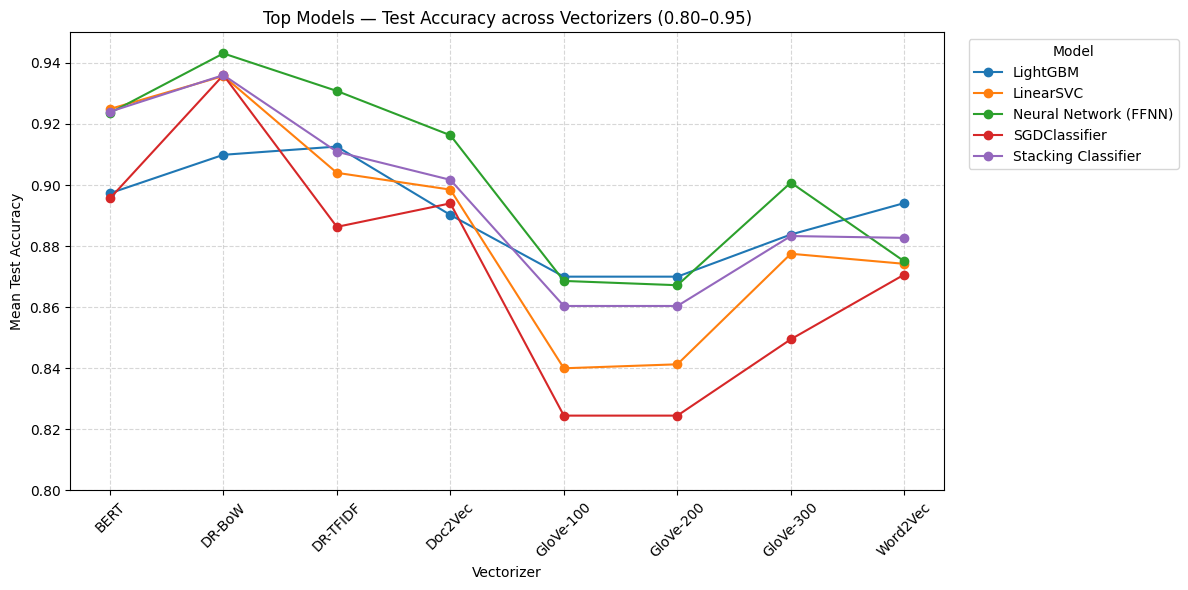

In [115]:
# Compare performance across vectorizers for TOP models

df['Test Accuracy'] = pd.to_numeric(df['Test Accuracy'], errors='coerce')
top_models = [
    "Neural Network (FFNN)",
    "LightGBM",
    "Stacking Classifier",
    "SGDClassifier",
    "LinearSVC",
]

plot_df = (
    df[df['Model'].isin(top_models)]
    .groupby(['Vectorizer', 'Model'], as_index=False)['Test Accuracy']
    .mean()
)

pivot_top = plot_df.pivot(index='Vectorizer', columns='Model', values='Test Accuracy')
pivot_top = pivot_top.sort_index()

plt.figure(figsize=(12, 6))
for model in pivot_top.columns:
    plt.plot(pivot_top.index, pivot_top[model], marker='o', label=model)

plt.title("Top Models — Test Accuracy across Vectorizers (0.80–0.95)")
plt.xlabel("Vectorizer")
plt.ylabel("Mean Test Accuracy")
plt.ylim(0.80, 0.95)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [116]:
print("Best model for each vectorizer by Test Accuracy (entire rows)")

df['Test Accuracy'] = pd.to_numeric(df['Test Accuracy'], errors='coerce')

best_by_vec_acc = (
    df.loc[df.groupby('Vectorizer')['Test Accuracy'].idxmax()]
      .sort_values('Vectorizer')
      .reset_index(drop=True)
)
print(best_by_vec_acc.to_string(index=False))

Best model for each vectorizer by Test Accuracy (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
            LinearSVC       BERT         0.9328         0.9249            0.9290         0.9174           0.9232   0.9761  No
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
Neural Network (FFNN)   DR-TFIDF         0.9324         0.9308            0.9354         0.9232           0.9293   0.9803 Yes
Neural Network (FFNN)    Doc2Vec         0.9542         0.9163            0.8955         0.9396           0.9170   0.9743  No
             LightGBM  GloVe-100         0.9447         0.8700            0.8691         0.8665           0.8678   0.9421  No
             LightGBM  GloVe-200         0.9447         0.8700            0.8691         0.8665           0.8678   0.9421  No
                 LSTM  GloVe-300         0/9283         

In [117]:
#  WORST model for each vectorizer by Test Accuracy
print("Worst model for each vectorizer by Test Accuracy (entire rows)")

worst_by_vec_acc = (
    df.loc[df.groupby('Vectorizer')['Test Accuracy'].idxmin()]
      .sort_values('Vectorizer')
      .reset_index(drop=True)
)
print(worst_by_vec_acc.to_string(index=False))

Worst model for each vectorizer by Test Accuracy (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
        Decision Tree       BERT         0.9903         0.7466            0.7443         0.7392           0.7417   0.6805  No
        Decision Tree     DR-BoW          0.992         0.7902            0.7882         0.7847           0.7865   0.7383 Yes
Bernoulli Naive Bayes   DR-TFIDF         0.8067         0.8061            0.8019         0.8051           0.8035   0.8842 Yes
        Decision Tree    Doc2Vec         0.9933         0.6688            0.6646         0.6610           0.6628   0.6279  No
        Decision Tree  GloVe-100          0.994         0.7353            0.7235         0.7728           0.7291   0.7087  No
        Decision Tree  GloVe-200          0.994         0.7353            0.7348         0.7236           0.7291   0.7087  No
        Decision Tree  GloVe-300         0.9944        

In [118]:
#   BEST model for each vectorizer by F1-Score (Fake)
print("Best model for each vectorizer by F1-Score (Fake) (entire rows)")

df['F1-Score (Fake)'] = pd.to_numeric(df['F1-Score (Fake)'], errors='coerce')

best_by_vec_f1 = (
    df.loc[df.groupby('Vectorizer')['F1-Score (Fake)'].idxmax()]
      .sort_values('Vectorizer')
      .reset_index(drop=True)
)
print(best_by_vec_f1.to_string(index=False))

Best model for each vectorizer by F1-Score (Fake) (entire rows)
                Model Vectorizer Train Accuracy  Test Accuracy  Precision (Fake)  Recall (Fake)  F1-Score (Fake)  ROC-AUC PCA
            LinearSVC       BERT         0.9328         0.9249            0.9290         0.9174           0.9232   0.9761  No
Neural Network (FFNN)     DR-BoW         0.9784         0.9431            0.9442         0.9400           0.9421   0.9858 Yes
Neural Network (FFNN)   DR-TFIDF         0.9324         0.9308            0.9354         0.9232           0.9293   0.9803 Yes
Neural Network (FFNN)    Doc2Vec         0.9542         0.9163            0.8955         0.9396           0.9170   0.9743  No
             LightGBM  GloVe-100         0.9447         0.8700            0.8691         0.8665           0.8678   0.9421  No
Neural Network (FFNN)  GloVe-200         0.8608         0.8672            0.8500         0.8869           0.8680   0.9409  No
                 LSTM  GloVe-300         0/9283       

Boxplots — Performance distributions for each vectorizer (Test Accuracy)


/var/tmp/ipykernel_4294/659989058.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Vectorizer', y='Test Accuracy', palette='Set2')


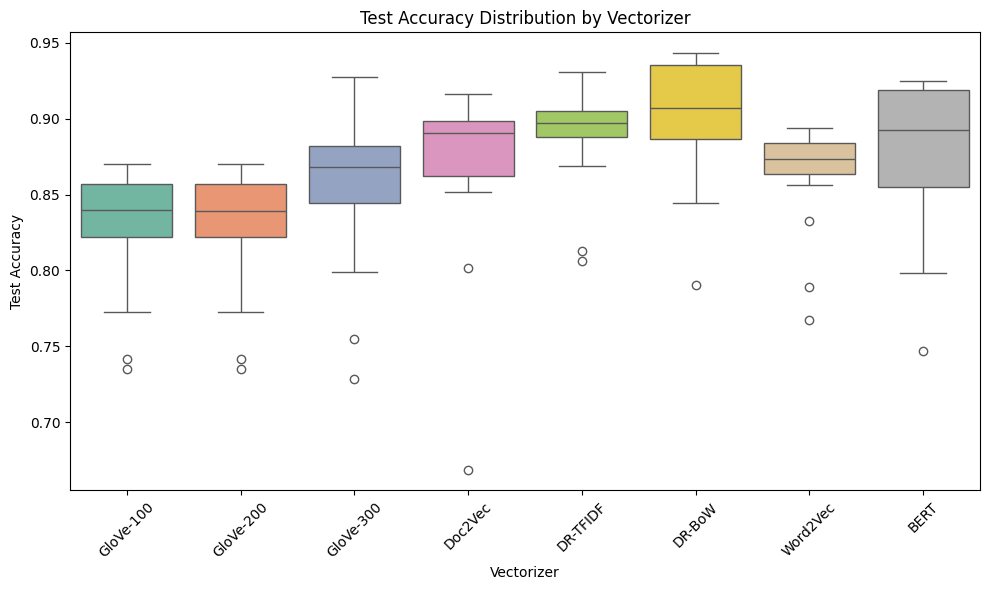

In [119]:
# Performance distributions for each vectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("Boxplots — Performance distributions for each vectorizer (Test Accuracy)")

df['Test Accuracy'] = pd.to_numeric(df['Test Accuracy'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Vectorizer', y='Test Accuracy', palette='Set2')
plt.xticks(rotation=45)
plt.title("Test Accuracy Distribution by Vectorizer")
plt.tight_layout()
plt.show()

Violin plots — Variability of models within a vectorizer (Test Accuracy)


/var/tmp/ipykernel_4294/3222182187.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Vectorizer', y='Test Accuracy', palette='Set3', inner='point')


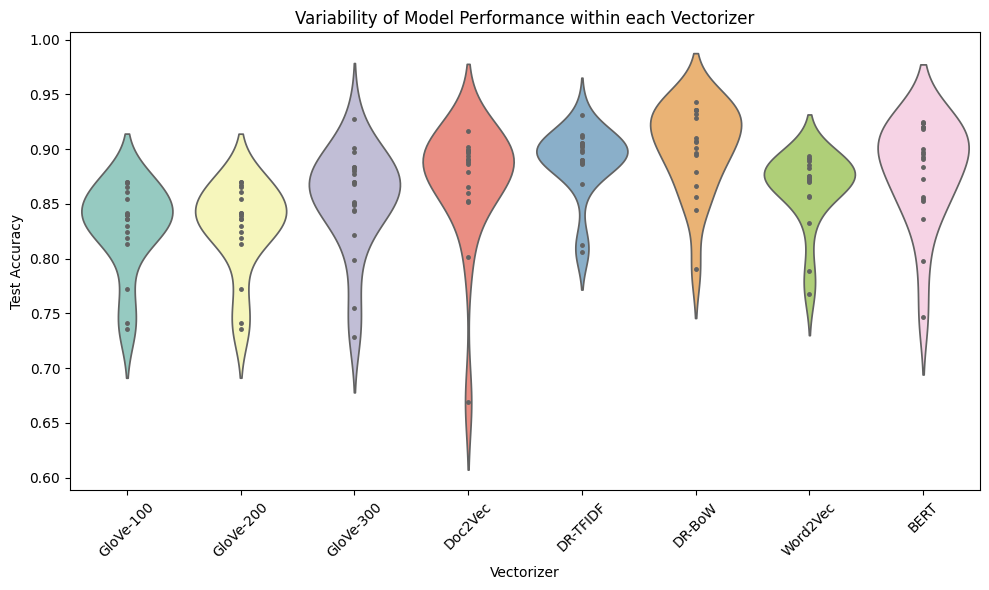

In [120]:
# Variability of models within a vectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("Violin plots — Variability of models within a vectorizer (Test Accuracy)")

df['Test Accuracy'] = pd.to_numeric(df['Test Accuracy'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Vectorizer', y='Test Accuracy', palette='Set3', inner='point')
plt.xticks(rotation=45)
plt.title("Variability of Model Performance within each Vectorizer")
plt.tight_layout()
plt.show()
